## Fastext своими руками

Fastext использует те же самые алгоритмы, что и word2vec. Единственное (но очень значимое) отличие в том, что в fastext используются не только слова, но и символьные нграммы. Это частично помогает решить проблему с несловарными словами. Если в словаре word2vec модели нет нужного слова, то никакого вектора для него создать не получится. В fastext же, если слова нет в словаре целиком, то можно проверить по словарю символьные нграммы этого слова и составить итоговый вектор из них. Большинство несловарных слов сильно пересекаются со словарными (основами, аффиксами) и за счет этого найденный вектор получается достаточно хороший. 
Реализовать простую версию fastext немного сложнее, поэтому я вынес его в отдельный ноутбук.

In [1]:
# import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline


In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.7.0


Возьмем тот же небольшой кусок википедии

In [3]:
# в нашем корпусе 20к текстов
wiki = open('wiki_data.txt').read().split('\n')

In [33]:
wiki[0]

'######Новостройка (Нижегородская область)############Новостро́йка — сельский посёлок в Дивеевском районе Нижегородской области. Входит в состав Сатисского сельсовета.############Посёлок расположен в 12,5 км к югу от села Дивеева и 1 км к западу от города Сарова, на правом берегу реки Вичкинза (правый приток реки Сатис). Окружён смешанными лесами. Соединён асфальтовой дорогой с посёлком Цыгановка (1,5 км) и грунтовыми просёлочными дорогами с посёлком Сатис (3,5 км). Название Новостройка является сугубо официальным, местное население использует исключительно альтернативное название — Хитрый. Употребляется языковой оборот «…на Хитром». Ранее используемые названия — Песчаный, Известковый.############Основан в 1920-х годах переселенцами из соседних сёл Аламасово и Нарышкино (расположенных соответственно в 8 и 14 км к западу в Вознесенском районе).############Традиционно в посёлке жили рабочие совхоза «Вперёд» (центр в посёлке Сатис). Возле посёлка расположен карьер где активно добывали дол

In [34]:
len(wiki)

20003

Базовая токенизация остается точно такой же

In [35]:
import re
from collections import Counter
def tokenize(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens


Второй базовый элемент - это нграммер, чтобы разбивать токен на символьные нграммы
Обратите внимание что к токену добавляются <> чтобы учесть в нграммах, что они стоят в начале или в конце

In [ ]:
def ngrammer(raw_string, n=2):
    ngrams = []
    raw_string = ''.join(['<', raw_string, '>'])
    for i in range(0,len(raw_string)-n+1):
        ngram = ''.join(raw_string[i:i+n])
        if ngram == '<' or ngram == '>': # сами по себе <> как токены не нужны
            continue
        ngrams.append(ngram)
    return ngrams

Следующая функция проходится по токенам и разбивает каждый токен на подсимвольные нграммы в заданном интервале

In [36]:
def split_tokens(tokens, min_ngram_size, max_ngram_size):
    tokens_with_subwords = []
    for token in tokens:
        subtokens = []
        for i in range(min_ngram_size, max_ngram_size+1):
            if len(token) > i:
                subtokens.extend(ngrammer(token, i))
        tokens_with_subwords.append(subtokens)
    return tokens_with_subwords


In [41]:
split_tokens(['подсимвольные', 'нграммы'], 3, 4)

[['<по',
  'под',
  'одс',
  'дси',
  'сим',
  'имв',
  'мво',
  'вол',
  'оль',
  'льн',
  'ьны',
  'ные',
  'ые>',
  '<под',
  'подс',
  'одси',
  'дсим',
  'симв',
  'имво',
  'мвол',
  'воль',
  'ольн',
  'льны',
  'ьные',
  'ные>'],
 ['<нг',
  'нгр',
  'гра',
  'рам',
  'амм',
  'ммы',
  'мы>',
  '<нгр',
  'нгра',
  'грам',
  'рамм',
  'аммы',
  'ммы>']]

Теперь нам нужно спаппить токены и подсимвольные нграммы в индексы и для этого нужно построить словарь. Это немного сложнее чем раньше потому что мы хотим иметь в словаре и полные слова и символьные нграммы, но нам нужно иметь отдельный список только полных слов, чтобы потом иметь возможность находить ближайшие слова.

Чтобы было удобнее со всеми переменными напишем класс для токенизации

In [42]:
class SubwordTokenizer:
    def __init__(self, ngram_range=(1,1), min_count=5):
        self.min_ngram_size, self.max_ngram_size = ngram_range
        self.min_count = min_count
        self.subword_vocab = None
        self.fullword_vocab = None
        self.vocab = None
        self.id2word = None
        self.word2id = None

    def build_vocab(self, texts):
        # чтобы построить словарь нужно пройти по всему корпусу и собрать частоты всех уникальных слов и нграммов
        unfiltered_subword_vocab = Counter()
        unfiltered_fullword_vocab = Counter()
        for text in texts:
            tokens = tokenize(text)
            unfiltered_fullword_vocab.update(tokens)
            subwords_per_token = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
            for subwords in subwords_per_token:
                # в одном слове могут быть одинаковые нграммы поэтому возьмем только уникальные
                unfiltered_subword_vocab.update(set(subwords))

        self.fullword_vocab = set()
        self.subword_vocab = set()

        # теперь отфильтруем по частоте
        for word, count in unfiltered_fullword_vocab.items():
            if count >= self.min_count:
                self.fullword_vocab.add(word)
        # для нграммов сделаем порог побольше чтобы не создавать слишком много нграммов
        # и учитывать только действительно частотные
        for word, count in unfiltered_subword_vocab.items():
            if count >= (self.min_count * 100):
                self.subword_vocab.add(word)

        # общий словарь
        self.vocab = self.fullword_vocab | self.subword_vocab
        self.id2word = {i:word for i,word in enumerate(self.vocab)}
        self.word2id = {word:i for i,word in self.id2word.items()}

    def subword_tokenize(self, text):
        if self.vocab is None:
            raise AttributeError('Vocabulary is not built!')
        # разбиваем на токены
        tokens = tokenize(text) 
        # каждый токен разбиваем на символьные нграммы
        tokens_with_subwords = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
        # оставляет только токены и нграммы которые есть в словаре
        only_vocab_tokens_with_subwords = []
        for full_token, sub_tokens in zip(tokens, tokens_with_subwords):
            filtered = []
            if full_token in self.vocab:
                # само слово и нграммы хранятся в одном списке 
                # но слово будет всегда первым в списке
                filtered.append(full_token)
            filtered.extend([subtoken for subtoken in set(sub_tokens) if subtoken in self.vocab])
            only_vocab_tokens_with_subwords.append(filtered)

        return only_vocab_tokens_with_subwords

    def encode(self, subword_tokenized_text):
        # маппим токены и нграммы в их индексы в словаре
        encoded_text = []
        for token in subword_tokenized_text:
            if not token:
                continue
            encoded_text.append([self.word2id[token[0]]] + [self.word2id[t] for t in set(token[1:]) if t in self.word2id and t != token[0]])
        return encoded_text

    def __call__(self, text):
        return self.encode(self.subword_tokenize(text))


In [5]:
tokenizer = SubwordTokenizer(ngram_range=(2,4), min_count=10)

In [6]:
tokenizer.build_vocab(wiki)

In [7]:
tokenizer.subword_tokenize('Текст для тестирования токенизации')

[['текст',
  'текс',
  'ст',
  'кс',
  'екс',
  'т>',
  'ек',
  'те',
  'кст',
  'екст',
  'тек',
  '<т',
  'ст>',
  '<те',
  '<тек'],
 ['для', '<д', 'я>', 'ля', 'дл'],
 ['тестирования',
  'ова',
  'ан',
  'ни',
  'ти',
  'ров',
  'ован',
  '<те',
  'ван',
  'вани',
  'ва',
  'ия>',
  'тес',
  'ир',
  'ест',
  'тест',
  'сти',
  'ов',
  'иров',
  'ст',
  'иро',
  'ро',
  'ес',
  'те',
  'рова',
  'тир',
  'ани',
  'тиро',
  'ния>',
  'ания',
  'я>',
  'ния',
  'ия',
  'ести',
  '<т'],
 ['ок',
  'изац',
  'ни',
  'ции',
  'низ',
  'ке',
  'токе',
  'иза',
  'заци',
  'кен',
  'низа',
  'то',
  'ен',
  'ции>',
  'ации',
  'за',
  'оке',
  'ии',
  'ци',
  '<то',
  'из',
  'зац',
  'ии>',
  'ток',
  'аци',
  'ац',
  'ени',
  'и>',
  '<т']]

In [8]:
len(tokenizer.vocab)

54860

In [9]:
tokenizer('Текст для тестирования токенизации')

[[37556,
  37816,
  5387,
  21821,
  40639,
  232,
  29939,
  12077,
  28470,
  36788,
  35065,
  29134,
  29895,
  12488,
  41021],
 [43685, 13609, 34940, 53748, 42650],
 [21417,
  52144,
  52302,
  47504,
  7436,
  4403,
  7017,
  12488,
  33500,
  35456,
  21986,
  2536,
  43290,
  32251,
  18137,
  51963,
  17779,
  45932,
  23190,
  5387,
  48524,
  15542,
  42860,
  12077,
  39475,
  32715,
  28598,
  13683,
  31852,
  44946,
  42650,
  8607,
  2517,
  47931,
  29134],
 [14329,
  12253,
  47504,
  51941,
  18178,
  18343,
  22145,
  41053,
  51951,
  27494,
  47954,
  15636,
  3867,
  49478,
  35078,
  9832,
  26939,
  30180,
  46676,
  39145,
  31268,
  51777,
  51183,
  49294,
  8608,
  8534,
  42309,
  54054,
  29134]]

Реализуем функцию которая будет генерировать батчи для обучения. Сделаем только скипграмм алгоритм. То есть нам нужны пары токен_1 - токен_2 встретившиеся в одном контексте, только для токена_1 мы еще будет учитывать его символьный нграммы, а токен_2 будет предсказывать только целиком без разбиение на поднграммы

In [12]:
def gen_batches_ft(sentences, tokenizer, window = 5, batch_size=1000, maxlen=20):
    
    
    left_context_length = (window/2).__ceil__() 
    right_context_length = window // 2 
    
    while True:
        X = []
        y = []

        for sent in sentences:
            sent = tokenizer(sent)
            for i in range(len(sent)-1):
                word_with_subtokens = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word_with_subtokens in context:
                    # целевой токен всегда только целый
                    # мы берем первый токен из списка который вернул токенайзер
                    # там у нас будет лежать целое слово
                    only_full_word_context_token = context_word_with_subtokens[0]
                    X.append(word_with_subtokens)
                    y.append(only_full_word_context_token)
                    
                    if len(X) >= batch_size:
                        # тут нам понадобится паддинг так как количество сивольных нграммов будет зависеть от длины токенов
                        X = np.array(keras.preprocessing.sequence.pad_sequences(X, maxlen=maxlen))
                        y = np.array(y)
                        yield (X, y)
                        X = []
                        y = []

In [13]:
gen = gen_batches_ft(wiki, tokenizer, batch_size=5)

In [14]:
next(gen)

(array([[22947, 48282, 27145, 28792, 48513, 27753, 37977, 21663, 45932,
         29743,  5387, 15542, 33635, 22329, 48311, 29820, 16903, 23157,
         36562, 20455],
        [15542, 28135, 31314, 14369, 54155, 17429, 31723,  2060,  5459,
         40183, 12578,  6739, 48311, 53991, 24519, 42650, 16903, 53597,
         44043, 14847],
        [15542, 28135, 31314, 14369, 54155, 17429, 31723,  2060,  5459,
         40183, 12578,  6739, 48311, 53991, 24519, 42650, 16903, 53597,
         44043, 14847],
        [28777, 40888, 49411, 43813, 23294, 24160, 27451,  5387, 18150,
         50203, 45708,  5560, 25165, 40453, 51307, 44032, 47585, 31736,
         19321, 39041],
        [28777, 40888, 49411, 43813, 23294, 24160, 27451,  5387, 18150,
         50203, 45708,  5560, 25165, 40453, 51307, 44032, 47585, 31736,
         19321, 39041]], dtype=int32),
 array([19249, 15749,  1974, 15749, 19249]))

Код для обучения очень простой. Мы просто сопостовляет каждому токену и нграмму эмбединг и усредняем все эмбединги внутри слова, чтобы получить итоговый. По нему мы пытаемся предсказать целевое слово.

In [15]:
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=len(tokenizer.vocab), 
                                 output_dim=100))
model.add(keras.layers.Lambda(lambda x: x.mean(axis=1)))

model.add(keras.layers.Dense(len(tokenizer.vocab), activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy')

In [16]:
model.build((None, 10))

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 100)        │     5,486,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 54860)          │     5,540,860 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,026,860 (42.06 MB)

 Trainable params: 11,026,860 (42.06 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.fit(gen_batches_ft(wiki[:19000],tokenizer, window=10, batch_size=100),
          validation_data=gen_batches_ft(wiki[19000:], tokenizer, window=10, batch_size=100),
          batch_size=2000,
          steps_per_epoch=10000,
          validation_steps=100,
          epochs=10)

Epoch 1/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - loss: 9.7646 - val_loss: 9.0602
Epoch 2/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 95s 10ms/step - loss: 8.7069 - val_loss: 8.9834
Epoch 3/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 95s 10ms/step - loss: 8.6458 - val_loss: 8.4618
Epoch 4/10
 1135/10000 ━━━━━━━━━━━━━━━━━━━━ 1:23 9ms/step - loss: 8.6795

KeyboardInterrupt: 

dict_keys(['loss', 'val_loss'])


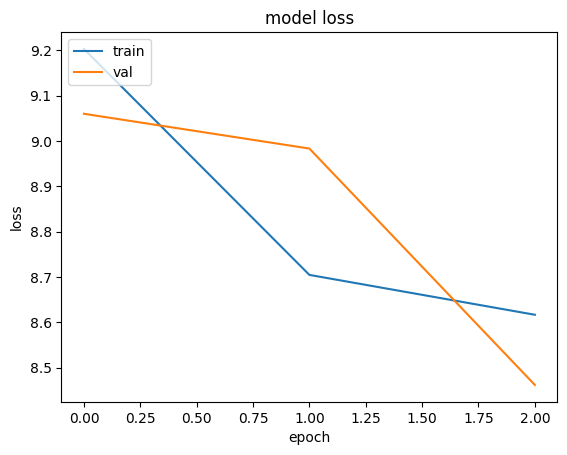

In [19]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Искать похожие немного сложнее так как нам нужно для всех полных слов еще и учесть информацию об их поднграммах.

In [20]:
embeddings = model.layers[0].get_weights()[0] # матрица со всеми эмбедингами

In [43]:
full_word_embeddings = np.zeros((len(tokenizer.fullword_vocab), 100)) # матрица с эмбедингами полных слов + нграммы
id2word = list(tokenizer.fullword_vocab)

for i, word in enumerate(tokenizer.fullword_vocab):
    subwords = tokenizer(word)[0]
    full_word_embeddings[i] = embeddings[[i for i in subwords]].mean(axis=0) 

In [44]:
def most_similar_ft(word, embeddings, tokenizer):
    subwords = tokenizer(word)[0]
    word_embedding = embeddings[[i for i in subwords]].sum(axis=0)
    # idxs = [tokenizer.word2id[i] for i in tokenizer.fullword_vocab]
    similar = [id2word[i] for i in 
               cosine_distances(word_embedding.reshape(1, -1), full_word_embeddings).argsort()[0][:20]]
    return similar

Из результатов поиска видно что fastext учитывает поднграмы и находит как ближайшие не только близкие по смыслу но и по форме

In [45]:
most_similar_ft('семья', embeddings, tokenizer)

['семья',
 'семьях',
 'семь',
 'семьям',
 'семьей',
 'семью',
 'семьёй',
 'семьями',
 'семье',
 'семьи',
 'семьи»',
 'восемь',
 'восемью',
 'семнадцать',
 'километрах',
 'семнадцатый',
 'непосредственном',
 'совместном',
 'сельские',
 'северо-западных']

In [46]:
most_similar_ft("церковь", embeddings, tokenizer)

['церковь',
 '«церковь',
 'церковью',
 'церковную',
 'церковная',
 'церковное',
 'церковном',
 'церковным',
 'церковного',
 'церковному',
 'церковные',
 'церковной',
 'церковных',
 'церковно-приходская',
 'церковный',
 'церквях',
 'суперкомпьютер',
 'бхактиведанты',
 'гребенщиков',
 'техникуме']

In [47]:
most_similar_ft("делать", embeddings, tokenizer)

['делать',
 'сделать',
 'делалось',
 'проделать',
 'дела',
 'дебютировать',
 'делались',
 'делался',
 'делал',
 'делают',
 'оплачивать',
 'дела»',
 'делилась',
 'нур-трёнделаг',
 'использовать',
 'сдавать',
 'делало',
 'делах',
 'демонстрировать',
 'переделать']